In [1]:
%pip install pvlib --quiet

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Documents\irradiance\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import h5py
from tqdm import tqdm
import scipy.stats as stats

sys.path.append('..')

from src.data import load_data, get_africa_mask
from src.utils import convert_pixel_to_coordinates
from src import config

In [6]:
from pvlib import pvsystem, location, modelchain, irradiance

,ghi,dni,dhi
2019-01-01 06:00:00-05:00,822.276746,782.659302,169.526207
2019-01-01 06:05:00-05:00,824.443446,783.336116,169.715732
2019-01-01 06:10:00-05:00,826.094277,783.850188,169.859916
2019-01-01 06:15:00-05:00,827.228344,784.202541,169.958857
2019-01-01 06:20:00-05:00,827.845037,784.393874,170.012623


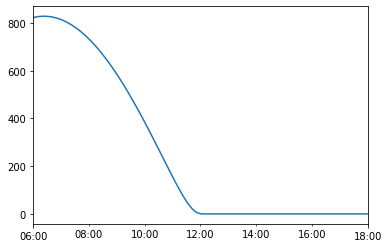

In [7]:
loc = location.Location(10, 10)
times = pd.date_range(
    "2019-01-01 06:00", "2019-01-01 18:00", freq="5min", tz="Etc/GMT+5"
)
weather = loc.get_clearsky(times)
weather.ghi.plot()
weather.head()

In [8]:
def search_day_max(loc_x: int, loc_y: int, day: str = "2019-01-01"):
    """Search the max for one day."""
    lat, long = convert_pixel_to_coordinates(loc_x, loc_y)
    loc = location.Location(lat, long)
    times = pd.date_range(
        f"{day} 06:00", f"{day} 22:00", freq="1h", tz="Etc/GMT+5"
    )
    weather = loc.get_clearsky(times)
    return weather.ghi.max()
    

In [9]:
def search_day_AOI(loc_x: int, loc_y: int, day: str = "2019-01-01"):
    """Search the AOI for one day."""
    lat, long = convert_pixel_to_coordinates(loc_x, loc_y)
    loc = location.Location(lat, long)
    times = pd.date_range(
        f"{day} 00:15", f"{day} 23:45", freq="15min", tz="Etc/GMT+5"
    )
    weather = loc.get_solarposition(times)
    
    aoi = irradiance.aoi(0, 0, weather.apparent_zenith, weather.azimuth)
    return aoi.to_numpy()
search_day_AOI(200, 200)

array([ 85.8336211 ,  82.48409318,  79.10902788,  75.73547257,
        72.37438723,  69.03269084,  65.71631257,  62.43128988,
        59.18433842,  55.98327869,  52.83745495,  49.7582134 ,
        46.75947896,  43.85845791,  41.07648188,  38.43997125,
        35.98142665,  33.74022987,  31.76282334,  30.10157941,
        28.81151689,  27.94430047,  27.54004271,  27.61914532,
        28.17753192,  29.18763476,  30.60462462,  32.37492749,
        34.44386572,  36.76076056,  39.28142574,  41.96878216,
        44.79241341,  47.72766713,  50.75465666,  53.85733106,
        57.02267667,  60.2400582 ,  63.50067778,  66.79712074,
        70.12294357,  73.47222145,  76.83887037,  80.21516938,
        83.58716163,  86.91406578,  90.01014811,  94.02638225,
        97.4742476 , 100.92482563, 104.37589952, 107.82518187,
       111.27024318, 114.70842692, 118.13674648, 121.55175651,
       124.94938415, 128.3247043 , 131.67163547, 134.98251682,
       138.2475136 , 141.45377205, 144.5842042 , 147.61

In [10]:
africa = np.zeros((config.RAW_DATA_WIDTH, config.RAW_DATA_HEIGHT, 95))

func = search_day_AOI

size = 2
with tqdm(total=int(config.RAW_DATA_HEIGHT * config.RAW_DATA_WIDTH)/size**2) as pbar:
    for x in range(0, config.RAW_DATA_WIDTH, size):
        for y in range(0, config.RAW_DATA_HEIGHT, size):
            val = func(x, y)
            africa[y:y+size, x:x+size] = val
            pbar.update(1)


35898it [05:56, 100.58it/s]                             


In [11]:
africa_mask = get_africa_mask()

In [17]:
# Generate all the images
from tqdm import tqdm

for image_idx in tqdm(range(africa.shape[-1])):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(africa[:, :, image_idx] * africa_mask, cmap="inferno_r")
    ax.set_title(f"AOI for {image_idx}")
    plt.savefig(f"../images/AOI/{str(image_idx).rjust(3,'0')}.png")
    plt.close()

100%|██████████| 95/95 [00:13<00:00,  6.85it/s]


In [18]:
# https://stackoverflow.com/a/57751793
import glob
from PIL import Image

# filepaths
fp_in = "../images/AOI/*.png"
fp_out = "../images/AOI_over_day.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(
    fp=fp_out, format="GIF", append_images=imgs, save_all=True, duration=100, loop=0
)